[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'AAPL Price'}, xlabel='Date'>

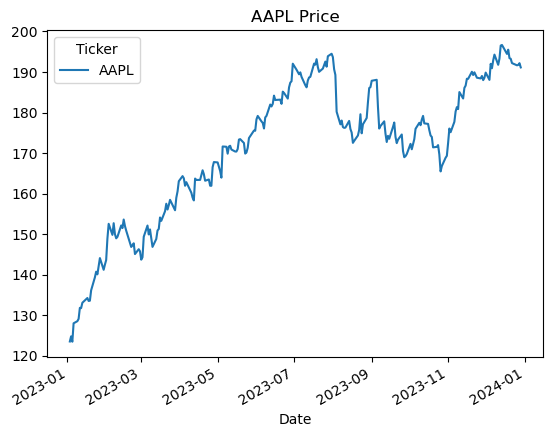

In [4]:
import yfinance as yf
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Download historical price data
ticker = "AAPL"
data = yf.download(ticker, start="2023-01-01", end="2023-12-31")
data = data['Close']
data.plot(title=f"{ticker} Price")

In [6]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def implied_volatility(market_price, S, K, T, r, option_type='call'):
    def difference(sigma):
        bs_price = black_scholes_price(S, K, T, r, sigma, option_type)
        return bs_price - market_price

    result = brentq(difference, 1e-6, 5)
    return result

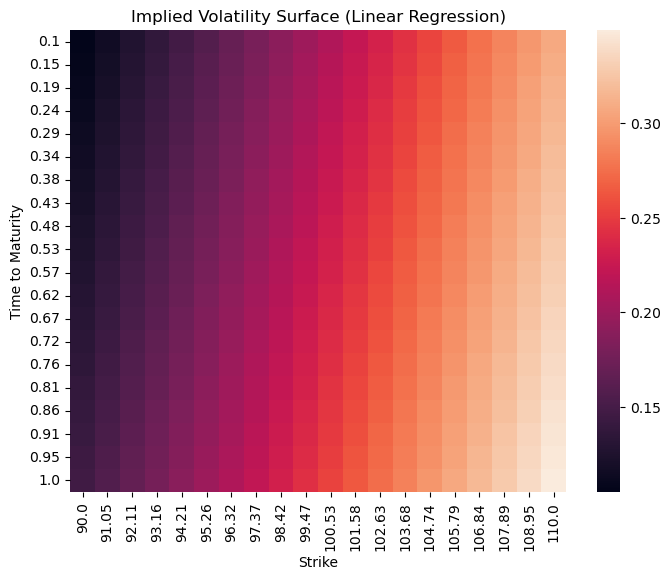

In [9]:
# Dummy data (replace with real market data)
np.random.seed(0)
K = np.linspace(90, 110, 20)
T = np.linspace(0.1, 1.0, 20)
K_grid, T_grid = np.meshgrid(K, T)
IV = 0.2 + 0.01 * (K_grid - 100) + 0.05 * T_grid + np.random.normal(0, 0.01, size=K_grid.shape)

X = np.column_stack([K_grid.ravel(), T_grid.ravel()])
y = IV.ravel()

reg = LinearRegression().fit(X, y)
IV_pred = reg.predict(X).reshape(K_grid.shape)

# Plot surface
plt.figure(figsize=(8,6))
sns.heatmap(IV_pred, xticklabels=np.round(K, 2), yticklabels=np.round(T, 2))
plt.title("Implied Volatility Surface (Linear Regression)")
plt.xlabel("Strike")
plt.ylabel("Time to Maturity")
plt.show()
